<a href="https://colab.research.google.com/github/hariansyahputra/Classification-Hijab-Use-Tensorflow-And-Implementation-Model-With-Augmented-Reality-in-Lens-Studio/blob/main/TrialAndErrorClassifyHijab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
import os
base_dir = '/content/drive/My Drive/datasets hijab classification'

train_dir = os.path.join(base_dir,'train')
validation_dir = os.path.join(base_dir, 'validation')

train_hijab_dir = os.path.join(train_dir, 'hijab')

train_nonhijab_dir = os.path.join(train_dir, 'nonhijab')

valid_hijab_dir = os.path.join(validation_dir, 'hijab')

valid_nonhijab_dir = os.path.join(validation_dir, 'nonhijab')

In [13]:
train_hijab_names = os.listdir(train_hijab_dir)
print(train_hijab_names[:10])

validation_hijab_names = os.listdir(valid_hijab_dir)
print(validation_hijab_names[:10])

train_nonhijab_names = os.listdir(train_nonhijab_dir)
print(train_nonhijab_names[:10])

['hijab.0915.jpg', 'hijab.0759.jpg', 'hijab.1176.jpg', 'hijab.1456.jpg', 'hijab.0710.jpg', 'hijab.1873.jpg', 'hijab.0616.jpg', 'hijab.1639.jpg', 'hijab.1530.jpg', 'hijab.1808.jpg']
['hijab.2015.jpg', 'hijab.2012.jpg', 'hijab.2014.jpg', 'hijab.2013.jpg', 'hijab.2008.jpg', 'hijab.2003.jpg', 'hijab.2005.jpg', 'hijab.2007.jpg', 'hijab.2057.jpg', 'hijab.2002.jpg']
['nonhijab.0041.jpg', 'nonhijab.0038.jpg', 'nonhijab.0036.jpg', 'nonhijab.0037.jpg', 'nonhijab.0040.jpg', 'nonhijab.0035.jpg', 'nonhijab.0034.jpg', 'nonhijab.0039.jpg', 'nonhijab.0033.jpg', 'nonhijab.0032.jpg']


In [14]:
print('train hijab images : ',len(os.listdir(train_hijab_dir)))
print('train nonhijab images:', len(os.listdir(train_nonhijab_dir)))
print('validation hijab images :', len(os.listdir(valid_hijab_dir)))
print('validation non hijab images :',len(os.listdir(valid_nonhijab_dir)))

train hijab images :  2000
train nonhijab images: 2000
validation hijab images : 500
validation non hijab images : 500


In [21]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

# Index for iterating over images
pic_index = 0



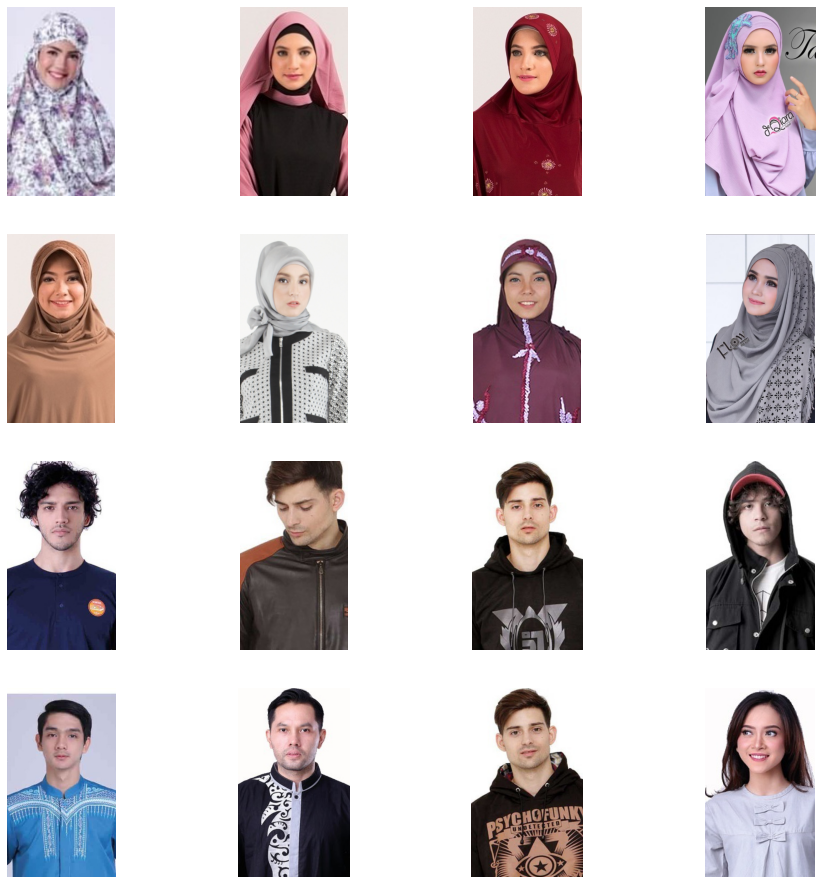

In [22]:
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches ( ncols*4, nrows*4)

pic_index += 8

next_hijab_pic = [os.path.join(train_hijab_dir,fname) 
for fname in train_hijab_names [pic_index -8 :pic_index]]
next_nonhijab_pic = [os.path.join(train_nonhijab_dir,fname)
for fname in train_nonhijab_names [pic_index-8 :pic_index]]

for i, img_path in enumerate(next_hijab_pic + next_nonhijab_pic):
    # Set up subplot; subplot indices start at 1

    sp = plt.subplot (nrows, ncols, i+1)
    sp.axis('Off') # Don't show axes (or gridlines)

    img = mpimg.imread(img_path)
    plt.imshow(img)

plt.show()

In [35]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale = 1/255)
valid_datagen = ImageDataGenerator(rescale = 1/255)

# Flow training images in batches of 120 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (150,150),
    batch_size = 200,
    class_mode = 'binary'
)

valid_generator = valid_datagen.flow_from_directory(
    validation_dir,
    target_size = (150, 150),
    batch_size = 200,
    class_mode = 'binary'
)

Found 4000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


Building the CNN model

In [36]:
import tensorflow as tf
import numpy as np
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve , auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_auc_score

from scipy import interp

In [37]:
model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 200x200 with 3 bytes color
    # This is the first convolution
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fourth convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # # The fifth convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('dandelions') and 1 for the other ('grass')
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [38]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 74, 74, 16)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 34, 34, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 17, 17, 64)      

In [39]:
from tensorflow.keras.optimizers import RMSprop

model.compile(loss= 'binary_crossentropy',
              optimizer = RMSprop(lr = 0.001),
              metrics = "accuracy")

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [41]:
history = model.fit(
    train_generator,
    steps_per_epoch = 20, # 4000 images = batchsize * step/epoch ( 20*200)
    epochs = 15,
    verbose = 1,
    validation_data = valid_generator,
    validation_steps = 5
)

Epoch 1/15
20/20 [==============================] - 972s 49s/step - loss: 0.6204 - accuracy: 0.6310 - val_loss: 0.9645 - val_accuracy: 0.5010
Epoch 2/15
20/20 [==============================] - 98s 5s/step - loss: 0.4180 - accuracy: 0.8235 - val_loss: 0.2710 - val_accuracy: 0.8870
Epoch 3/15
20/20 [==============================] - 98s 5s/step - loss: 0.2452 - accuracy: 0.8990 - val_loss: 0.2210 - val_accuracy: 0.9190
Epoch 4/15
20/20 [==============================] - 97s 5s/step - loss: 0.2020 - accuracy: 0.9150 - val_loss: 0.1555 - val_accuracy: 0.9480
Epoch 5/15
20/20 [==============================] - 97s 5s/step - loss: 0.1543 - accuracy: 0.9442 - val_loss: 0.1183 - val_accuracy: 0.9560
Epoch 6/15
20/20 [==============================] - 97s 5s/step - loss: 0.1289 - accuracy: 0.9485 - val_loss: 0.2146 - val_accuracy: 0.9020
Epoch 7/15
20/20 [==============================] - 97s 5s/step - loss: 0.0874 - accuracy: 0.9697 - val_loss: 0.1023 - val_accuracy: 0.9620
Epoch 8/15
20/20 [

In [42]:
model.evaluate(valid_generator)

5/5 [==============================] - 9s 2s/step - loss: 0.1098 - accuracy: 0.9550


[0.10982322692871094, 0.9549999833106995]

Saving nonhijab.0008.jpg to nonhijab.0008.jpg
[1.]
nonhijab.0008.jpg is a nonhijab


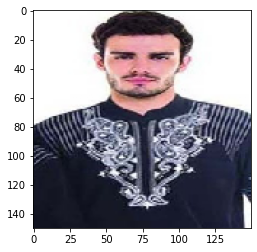

In [52]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = '/content/' + fn
  img = image.load_img(path, target_size=(150, 150))
  x = image.img_to_array(img)
  plt.imshow(x/255.)
  x = np.expand_dims(x, axis=0)
  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(classes[0])
  if classes[0]<0.5:
    print(fn + " is a hijab")
  else:
    print(fn + " is a nonhijab")
 